(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg BayesFitUtils

# Import project package
import BayesFitUtils

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import Tables

# Import basic statistical functions
import StatsBase
import Distributions

# Import library to list files
import Glob

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitUtils.viz.theme_makie!()

# Fitness inference exploratory data analysis for Kinsler et al., 2020

In this notebook, we will explore the output of the inferences done on the
Kinsler et al., 2020 datasets.

## Loading data

Let's begin by loading the raw data.

In [2]:
df_counts = CSV.read(
    "$(git_root())/data/kinsler_2020/tidy_counts_no_anc.csv", DF.DataFrame
)

first(df_counts[:, DF.Not(:additional_muts)], 3)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral,category,count_sum,freq
,Int64,String31,String31,String15,String31,String15,Int64,String3,String3,Int64,String15,Bool,String7,Int64,Float64
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-T0,22,R1,T0,0,1.4%,false,glucose,29770,0.000738999
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-T0,629,R1,T0,0,1.4%,false,glucose,29770,0.0211287
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,118,R1,T0,0,1.4%,false,glucose,29770,0.00396372


## Loading non-hierarchical ADVI results

Next we list all of the `ADVI` `csv` files with the inference results.

In [3]:
# Define directory
out_dir = "$(git_root())/code/processing/kinsler_2020/output/" *
          "advi_meanfield_joint_inference"

# List files
files = Glob.glob("$(out_dir)/*csv"[2:end], "/")

println("# of files = $(length(files))")

# of files = 60


Now, let's loop through each output file, load the `CSV` and append it to a tidy
dataframe.

In [4]:
# Initialize dataframe to save ADVI results
df_advi = DF.DataFrame()

# Loop through files
for f in files
    # Split file name
    f_split = split(split(f, "/")[end], "_")

    # Extract file metadata
    env = replace(f_split[2], "env" => "")
    rep = replace(f_split[3], "rep" => "")
    rmT0 = parse(Bool, replace(f_split[4], "rmT0" => ""))
    n_samples = parse(Int64, replace(f_split[5], "samples" => ""))
    n_steps = parse(Int64, replace(f_split[6], "steps.csv" => ""))

    # Load ADVI results into memory removing redundant columns
    df_tmp = CSV.read(f, DF.DataFrame)[:, DF.Not([:rep, :env])]

    # Add metadata information
    DF.insertcols!(
        df_tmp,
        :env .=> env,
        :rep .=> rep,
        :rm_T0 .=> rmT0,
        :n_samples .=> n_samples,
        :n_steps .=> n_steps
    )

    # Add to df_advi
    DF.append!(df_advi, df_tmp)
end # for

first(df_advi, 5)

Row,mean,std,varname,vartype,id,env,rep,rm_T0,n_samples,n_steps
,Float64,Float64,String31,String31,String7,String,String,Bool,Int64,Int64
1,0.289986,0.00695816,s̲ₜ[1],pop_mean_fitness,N/A,0.2MKCl,R1,false,1,4500
2,0.35264,0.00714037,s̲ₜ[2],pop_mean_fitness,N/A,0.2MKCl,R1,false,1,4500
3,0.417238,0.00718749,s̲ₜ[3],pop_mean_fitness,N/A,0.2MKCl,R1,false,1,4500
4,0.412009,0.00736643,s̲ₜ[4],pop_mean_fitness,N/A,0.2MKCl,R1,false,1,4500
5,-1.57933,0.178612,logσ̲ₜ[1],pop_std,N/A,0.2MKCl,R1,false,1,4500


To facilitate the analysis, let's extract the values only of the mutant fitness.

In [5]:
# Extract mutatn fitness values
df_fitness = df_advi[(df_advi.vartype.=="bc_fitness"), :]

first(df_fitness, 5)

Row,mean,std,varname,vartype,id,env,rep,rm_T0,n_samples,n_steps
,Float64,Float64,String31,String31,String7,String,String,Bool,Int64,Int64
1,0.462942,0.0433399,s̲⁽ᵐ⁾[1],bc_fitness,53,0.2MKCl,R1,false,1,4500
2,0.209557,0.0712742,s̲⁽ᵐ⁾[2],bc_fitness,151,0.2MKCl,R1,false,1,4500
3,0.510598,0.0510418,s̲⁽ᵐ⁾[3],bc_fitness,262,0.2MKCl,R1,false,1,4500
4,0.379043,0.0764676,s̲⁽ᵐ⁾[4],bc_fitness,273,0.2MKCl,R1,false,1,4500
5,0.34953,0.102433,s̲⁽ᵐ⁾[5],bc_fitness,323,0.2MKCl,R1,false,1,4500


### Replicate-to-replicate variability

Let's take a look at the replicate-to-replicate variability for environments
with more than one replicate. First, let's plot the pairwise comparison. The
error bars will represent the 68\% credible region.

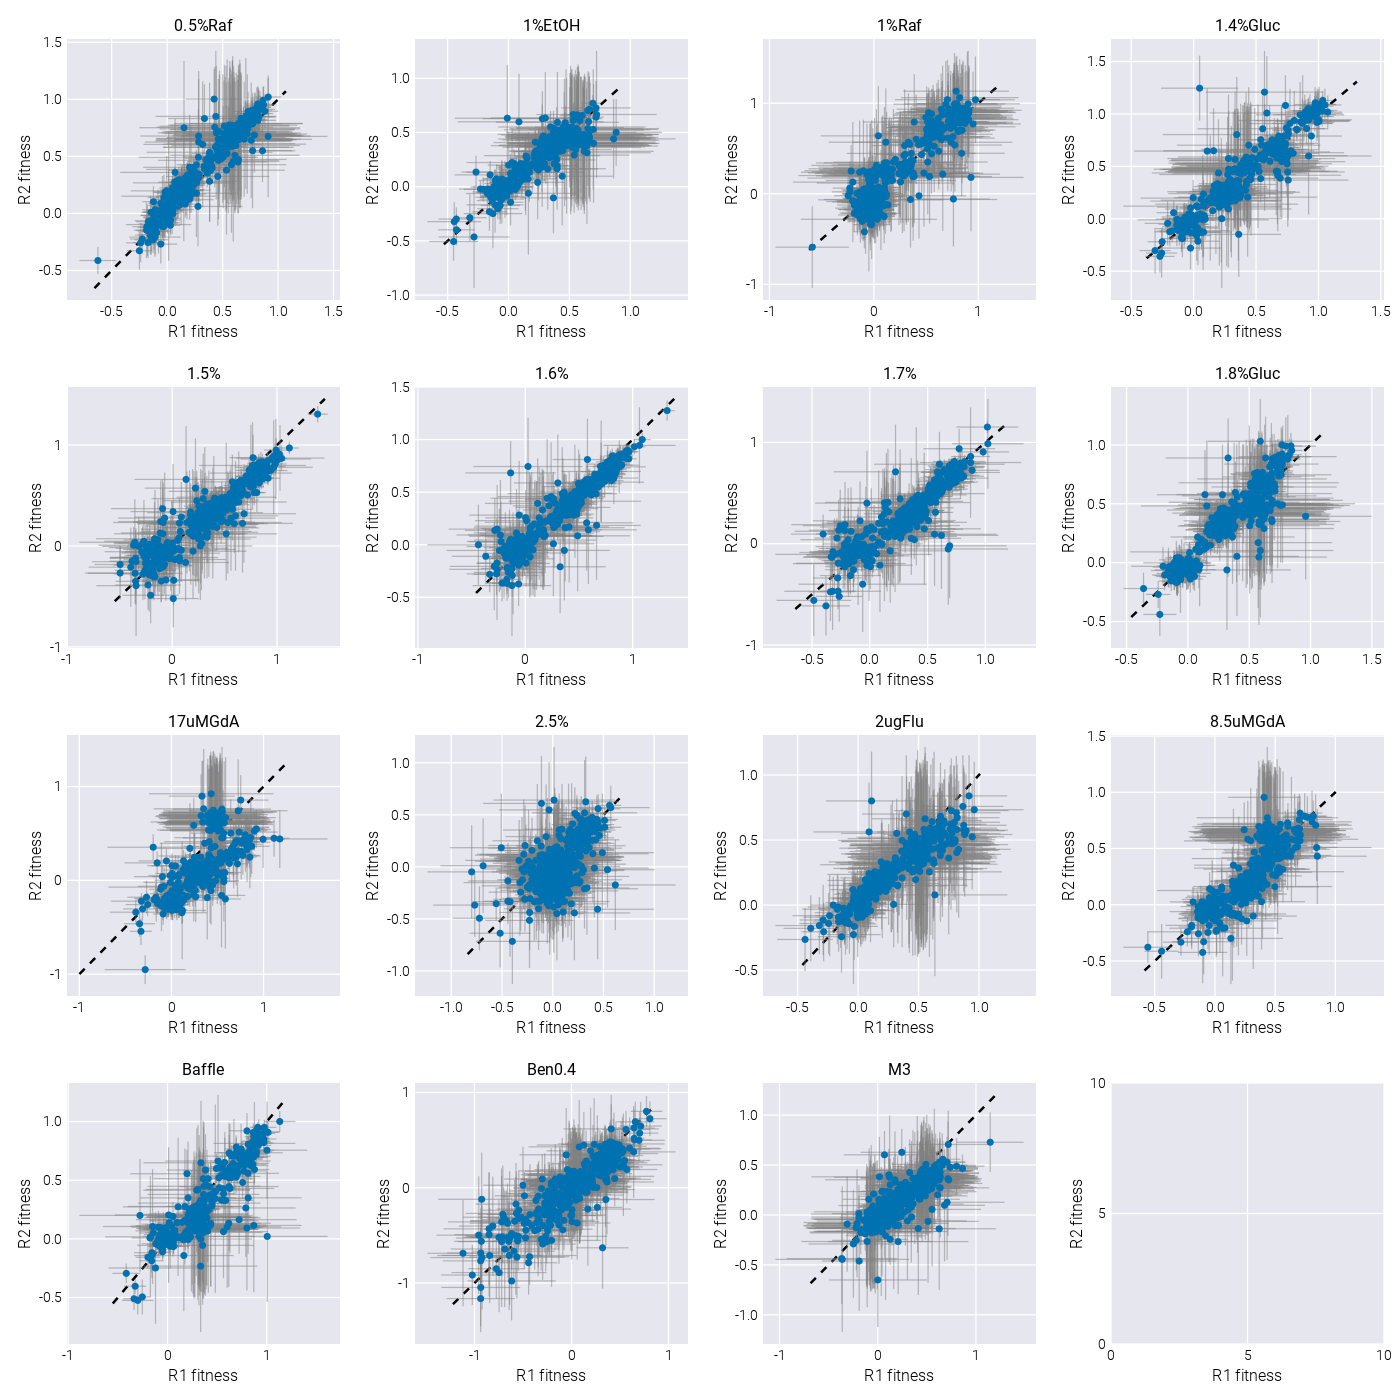

In [6]:
# Group data by environment
df_group = DF.groupby(df_fitness, :env)

# Find environments with two repeats
reps = [length(unique(g.rep)) for g in df_group] .≥ 2

# Keep groups with at least two repeats
df_reps = df_group[reps]

# Define number of rows and columns
n_row, n_col = [4, 4]

# Initialize figure
fig = Figure(resolution=(350 * n_col, 350 * n_row))

# Add GridLayout
gl = fig[1, 1] = GridLayout()

# Add axis
axes = [
    Axis(
        gl[i, j],
        xlabel="R1 fitness",
        ylabel="R2 fitness",
    ) for i = 1:n_row for j = 1:n_col
]

# Loop through groups
for (i, data) in enumerate(df_reps)
    # Plot Rep 1 vs Rep 2
    if first(data.env) == "M3"
        # Extract repeats to be used for M3
        data = data[(data.rep.=="R6").|(data.rep.=="R7"), :]
    end # if
    # Plot identity line
    lines!(
        axes[i],
        repeat([[minimum(data.mean) * 1.05, maximum(data.mean) * 1.05]], 2)...,
        color=:black,
        linestyle=:dash,
        linewidth=2.5
    )

    # Add x-axis error-bars
    errorbars!(
        axes[i],
        data[data.rep.==first(sort(unique(data.rep))), :mean],
        data[data.rep.==last(sort(unique(data.rep))), :mean],
        data[data.rep.==first(sort(unique(data.rep))), :std],
        color=(:gray, 0.5),
        direction=:x
    )
    # Add y-axis error-bars
    errorbars!(
        axes[i],
        data[data.rep.==first(sort(unique(data.rep))), :mean],
        data[data.rep.==last(sort(unique(data.rep))), :mean],
        data[data.rep.==last(sort(unique(data.rep))), :std],
        color=(:gray, 0.5),
        direction=:y
    )
    # Plot R1 vs R2
    scatter!(
        axes[i],
        data[data.rep.==first(sort(unique(data.rep))), :mean],
        data[data.rep.==last(sort(unique(data.rep))), :mean],
        markersize=10
    )
    # Add title
    axes[i].title = first(data.env)

end # for

fig

## Comparison with previous inference method

An important comparison to be made is with the previous inference method. Let's
load the previous fitness measurements.

In [7]:
# Load previous-method fitness inferences
df_prev = CSV.read(
    "$(git_root())/data/kinsler_2020/tidy_fitness_mle.csv", DF.DataFrame
)

# Initialize array where to save rep number. NOTE: This is done to split the 
# `EC Batch #`
rep = ones(Int64, size(df_prev, 1))

# Extract unique `EC Batch #` environments
ec_env = unique(df_prev.environment[occursin.("EC Batch", df_prev.environment)])

# Loop through EC envs
for env in ec_env
    # Extract and save replicate number
    rep[df_prev.environment.==env] .= parse(Int64, split(env, " ")[end])
    # Modify environment to be `EC Batch` only
    df_prev[df_prev.environment.==env, :environment] .= "EC Batch"
end # for

# Add rep column
df_prev[!, :rep] = ["R$(r)" for r in rep]

first(df_prev[:, DF.Not(:additional_muts)], 3)

Row,barcode,gene,type,ploidy,class,mutation_type,environment,fitness,error,rep
,Int64,String31,String31,String15,String31,String31,String31,Float64,Float64,String
1,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.28972,0.0312521,R19
2,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.323919,0.0452421,R3
3,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.165198,0.0751646,R6


This dataframe uses a different naming convention for the environments. The file
`env_equivalence.csv` is a manually-curated mapping between (most) environment
names. Let's map these names to the new environments.

Furthermore, we will add a column `:id` that matches the `df_fitness` `:id`
column.

In [8]:
# Read environment naming convention
df_env = CSV.read(
    "$(git_root())/data/kinsler_2020/env_equivalence.csv", DF.DataFrame
)

# Drop environemnts that have a missing entry
DF.dropmissing!(df_env)

# Initialize array to save new environment name
# envs = Array{Union{String,Missing}}(missing, size(df_prev, 1))
envs = repeat(["None"], size(df_prev, 1))

# Loop through old environments
for row in eachrow(df_env)
    # Add corresponding environment
    envs[df_prev.environment.==row.old] .= row.new
end # for

# Add columns to dataframe
DF.insertcols!(
    df_prev,
    :env => envs,
    :id => string.(df_prev.barcode)
)

first(df_prev[:, DF.Not(:additional_muts)], 3)

Row,barcode,gene,type,ploidy,class,mutation_type,environment,fitness,error,rep,env,id
,Int64,String31,String31,String15,String31,String31,String31,Float64,Float64,String,String,String
1,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.28972,0.0312521,R19,M3,53
2,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.323919,0.0452421,R3,M3,53
3,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.165198,0.0751646,R6,M3,53


To plot the comparison, we must find the environment/replicate pairs that appear
in both datasets as well as the common barcodes.

In [9]:
# Collect groups for previous inference
keys_prev = values.(keys(DF.groupby(df_prev, [:env, :rep])))

# Collect groups for new inference 
keys_fit = values.(keys(DF.groupby(df_fitness, [:env, :rep])))

# Find intersecting groups
keys_intersect = intersect(keys_prev, keys_fit)

# Find intersecting barcodes
bc_intersect = intersect(unique(df_fitness.id), unique(df_prev.id))

# Initialize dataframe to save comparison
df_comp = DF.DataFrame()

# Loop through datasets that overlap
for (i, (env, rep)) in enumerate(keys_intersect)
    # Extract df_fitness corresponding data
    df_f = df_fitness[
        (df_fitness.env.==env).&(df_fitness.rep.==rep).&([x ∈ bc_intersect for x in df_fitness.id]),
        :]
    # Extract df_prev corresponding data
    df_p = df_prev[
        (df_prev.env.==env).&(df_prev.rep.==rep),
        [:rep, :env, :id, :fitness, :error]
    ]
    # Join data
    DF.append!(
        df_comp,
        DF.leftjoin(df_f, df_p; on=[:env, :rep, :id])
    )

end # for

println("# envs = $(length(keys_intersect))")
println(
    "# barcodes = $(length(bc_intersect)) " *
    "out of $(length(unique(df_fitness.id)))"
)

# envs = 24
# barcodes = 418 out of 536


We see that a little over 100 barcodes were excluded from the original Kinsler
et al dataset. The authors did not explain why this is the case, so I'll need to
ask them directly.

Let's now plot the pairwise comparisons.

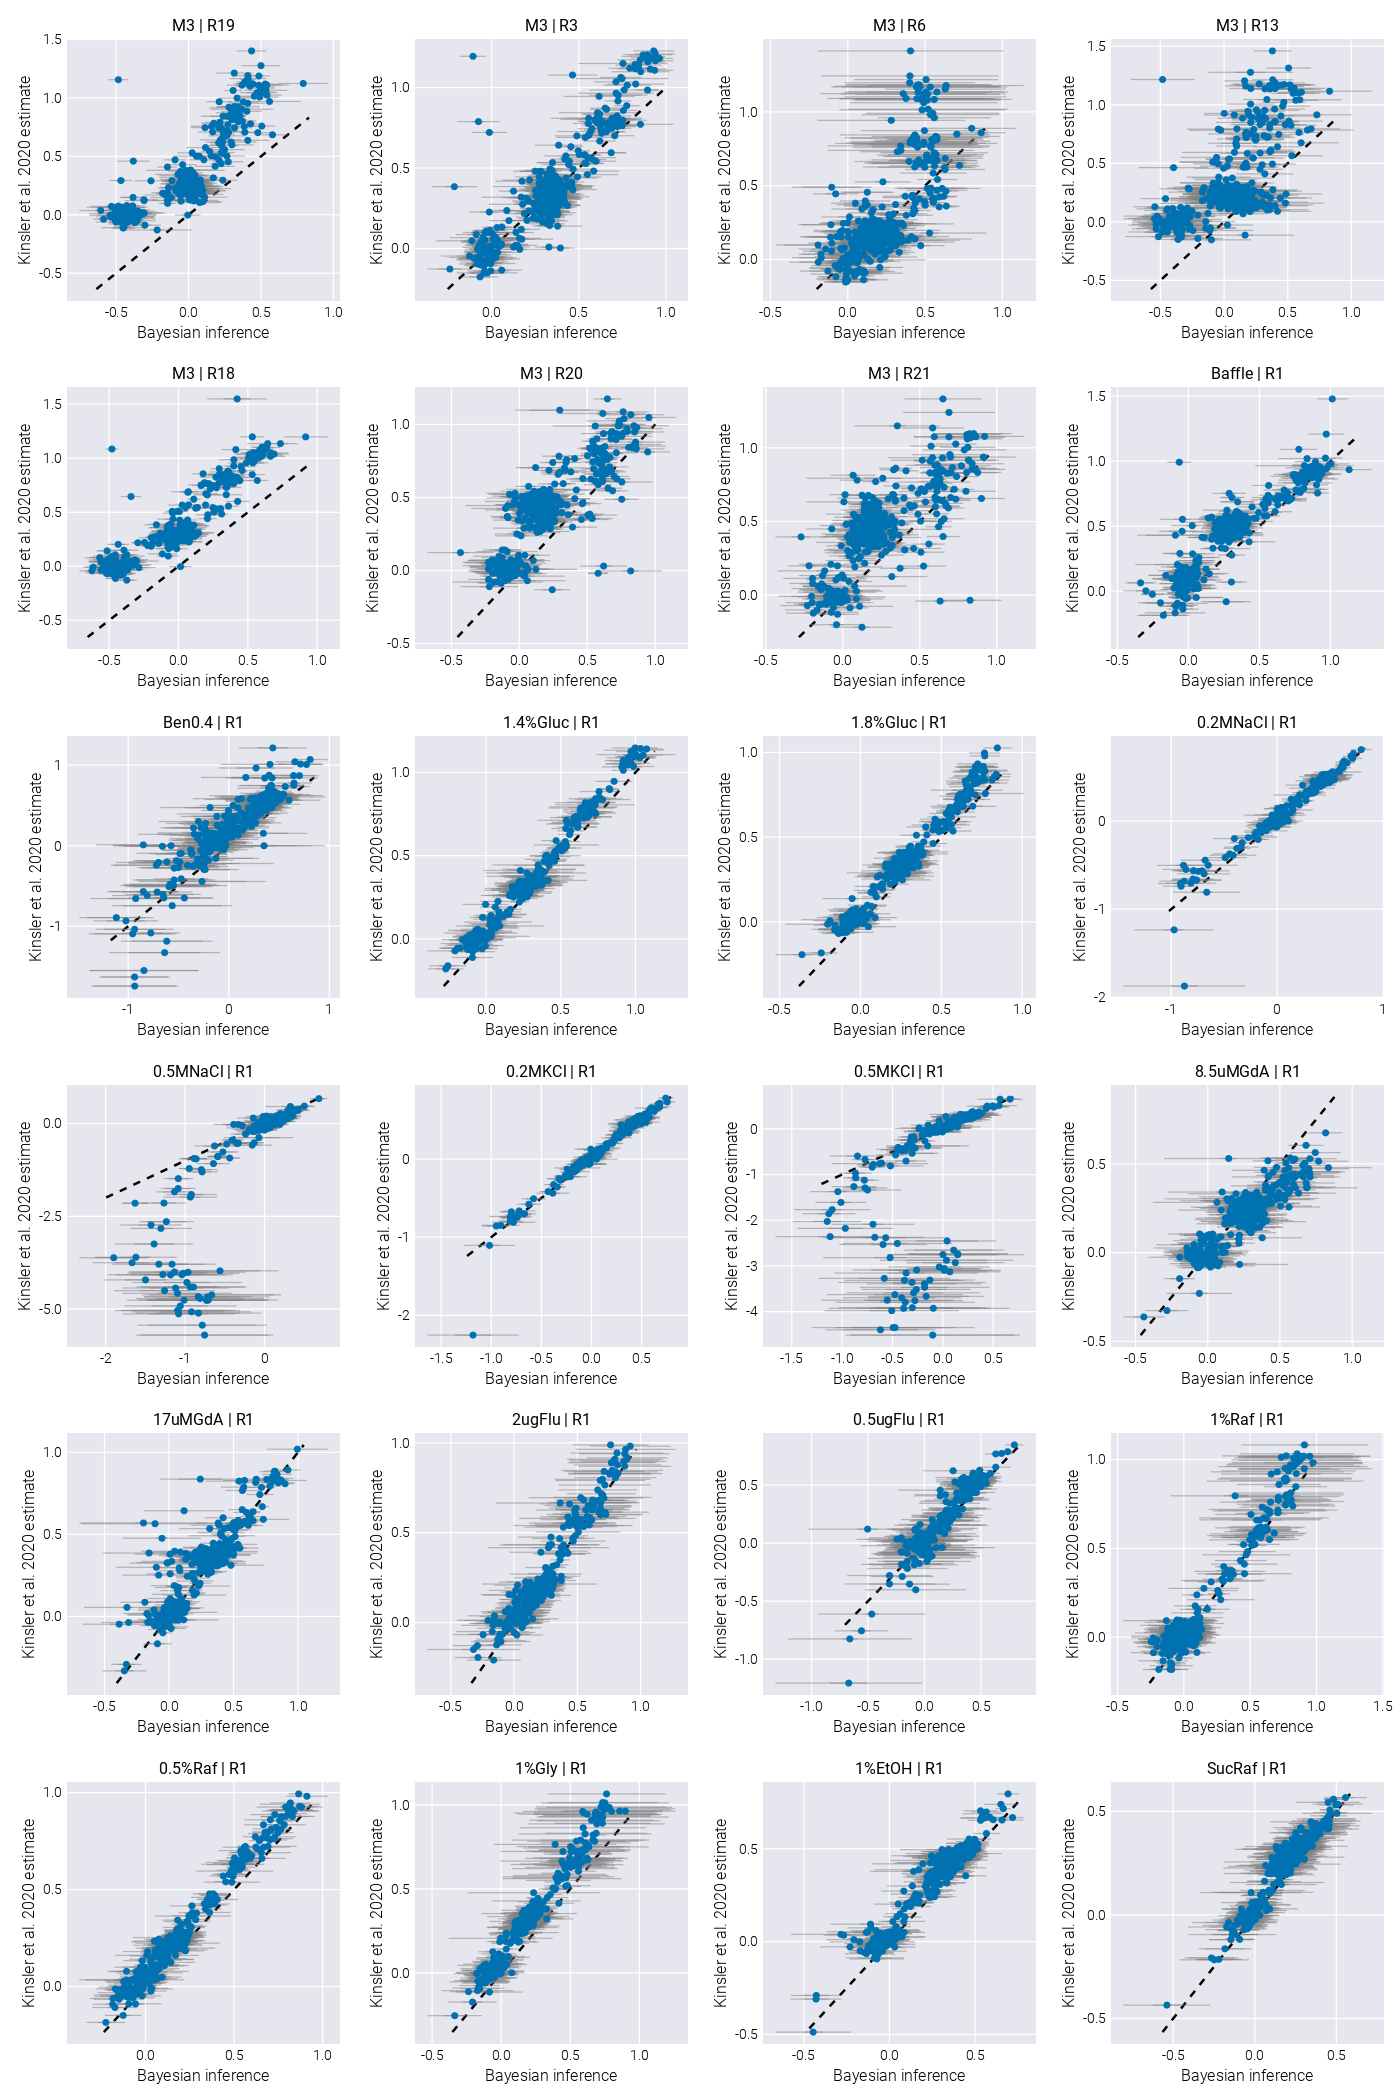

In [10]:

# Define number of rows and columns in subplots
n_col, n_row = [4, 6]

# Initialize figure
fig = Figure(resolution=(350 * n_col, 350 * n_row))

# Add GridLayout
gl = fig[1, 1] = GridLayout()

# Add axis
axes = [
    Axis(
        gl[i, j],
        xlabel="Bayesian inference",
        ylabel="Kinsler et al. 2020 estimate",
    ) for i = 1:n_row for j = 1:n_col
]

# Group data by environment and replicate
df_group = DF.groupby(df_comp, [:env, :rep])

# Loop through groups
for (i, data) in enumerate(df_group)
    # Plot identity line
    lines!(
        axes[i],
        repeat([[minimum(data.mean) * 1.05, maximum(data.mean) * 1.05]], 2)...,
        color=:black,
        linestyle=:dash,
        linewidth=2.5
    )
    # Add x-axis error-bars
    errorbars!(
        axes[i],
        data.mean,
        data.fitness,
        data.std,
        color=(:gray, 0.5),
        direction=:x
    )

    # Add y-axis error-bars
    errorbars!(
        axes[i],
        data.mean,
        data.fitness,
        data.error,
        color=(:gray, 0.5),
        direction=:x
    )

    # Plot comparisn
    scatter!(
        axes[i],
        data.mean,
        data.fitness,
        markersize=10
    )
    # Set title
    axes[i].title = "$(first(data.env)) | $(first(data.rep))"
end # for

fig

Although there are some suspiciously-diverging comparisons, these are mostly for
the M3 datasets, where I am less certain about the replicate number matching
with each other (something interesting to consider about the M3 data), the rest
of the comparisons look really good. As expected, the error bars from the
Bayesian inference look significantly bigger than with the older method.

## Loading hierarchical ADVI results

Next, let's look at the results from the hierarchical model for the cases where
there were visually validated experimental replicates. First, we list the files.

In [11]:
# Define directory
out_dir = "$(git_root())/code/processing/kinsler_2020/output/" *
          "advi_meanfield_hierarchicalreplicate_inference"

# List files
files = Glob.glob("$(out_dir)/*csv"[2:end], "/")

println("# of files = $(length(files))")

# of files = 15


Now, let's loop through each output file, load the `CSV` and append it to a tidy
dataframe.

In [12]:
# Initialize dataframe to save ADVI results
df_advi_hier = DF.DataFrame()
# Initialize dataframe to save bc fitness values
df_fitness = DF.DataFrame()

# Loop through files
for f in files
    # Split file name
    f_split = split(split(f, "/")[end], "_")

    # Extract file metadata
    env = replace(f_split[4], "env" => "")
    n_samples = parse(Int64, replace(f_split[5], "samples" => ""))
    n_steps = parse(Int64, replace(f_split[6], "steps.csv" => ""))

    # Load ADVI results into memory removing redundant columns
    df_tmp = CSV.read(f, DF.DataFrame)[:, DF.Not([:env])]

    # Add metadata information
    DF.insertcols!(
        df_tmp,
        :env .=> env,
        :n_samples .=> n_samples,
        :n_steps .=> n_steps
    )

    # Add to df_advi_hier
    DF.append!(df_advi_hier, df_tmp)

    # Extract bc fitness values
    df_fit = df_tmp[(df_tmp.vartype.=="bc_fitness"), :]

    # Extract and append hyperfitness values for each fitness value
    DF.leftjoin!(
        df_fit,
        DF.rename(
            df_tmp[(df_tmp.vartype.=="bc_hyperfitness"),
                [:mean, :std, :varname, :id]],
            :mean => :mean_h,
            :std => :std_h,
            :varname => :varname_h
        );
        on=:id
    )

    # Add to df_advi_hier
    DF.append!(df_fitness, df_fit)
end # for

first(df_fitness, 5)

Row,mean,std,varname,vartype,rep,id,env,n_samples,n_steps,mean_h,std_h,varname_h
,Float64,Float64,String31,String31,String3,String7,String,Int64,Int64,Float64?,Float64?,String31
1,0.258276,0.0909904,s̲⁽ᵐ⁾[1],bc_fitness,R1,53,0.5%Raf,1,10000,0.265424,0.0574944,θ̲⁽ᵐ⁾[1]
2,0.956258,0.0797749,s̲⁽ᵐ⁾[2],bc_fitness,R1,151,0.5%Raf,1,10000,0.963115,0.0559172,θ̲⁽ᵐ⁾[2]
3,0.235932,0.112208,s̲⁽ᵐ⁾[3],bc_fitness,R1,262,0.5%Raf,1,10000,0.240419,0.0731248,θ̲⁽ᵐ⁾[3]
4,0.73671,0.0966972,s̲⁽ᵐ⁾[4],bc_fitness,R1,273,0.5%Raf,1,10000,0.743078,0.0631047,θ̲⁽ᵐ⁾[4]
5,0.614698,0.104372,s̲⁽ᵐ⁾[5],bc_fitness,R1,323,0.5%Raf,1,10000,0.609018,0.0707414,θ̲⁽ᵐ⁾[5]


Let's look at the local fitness comparison between replicates.

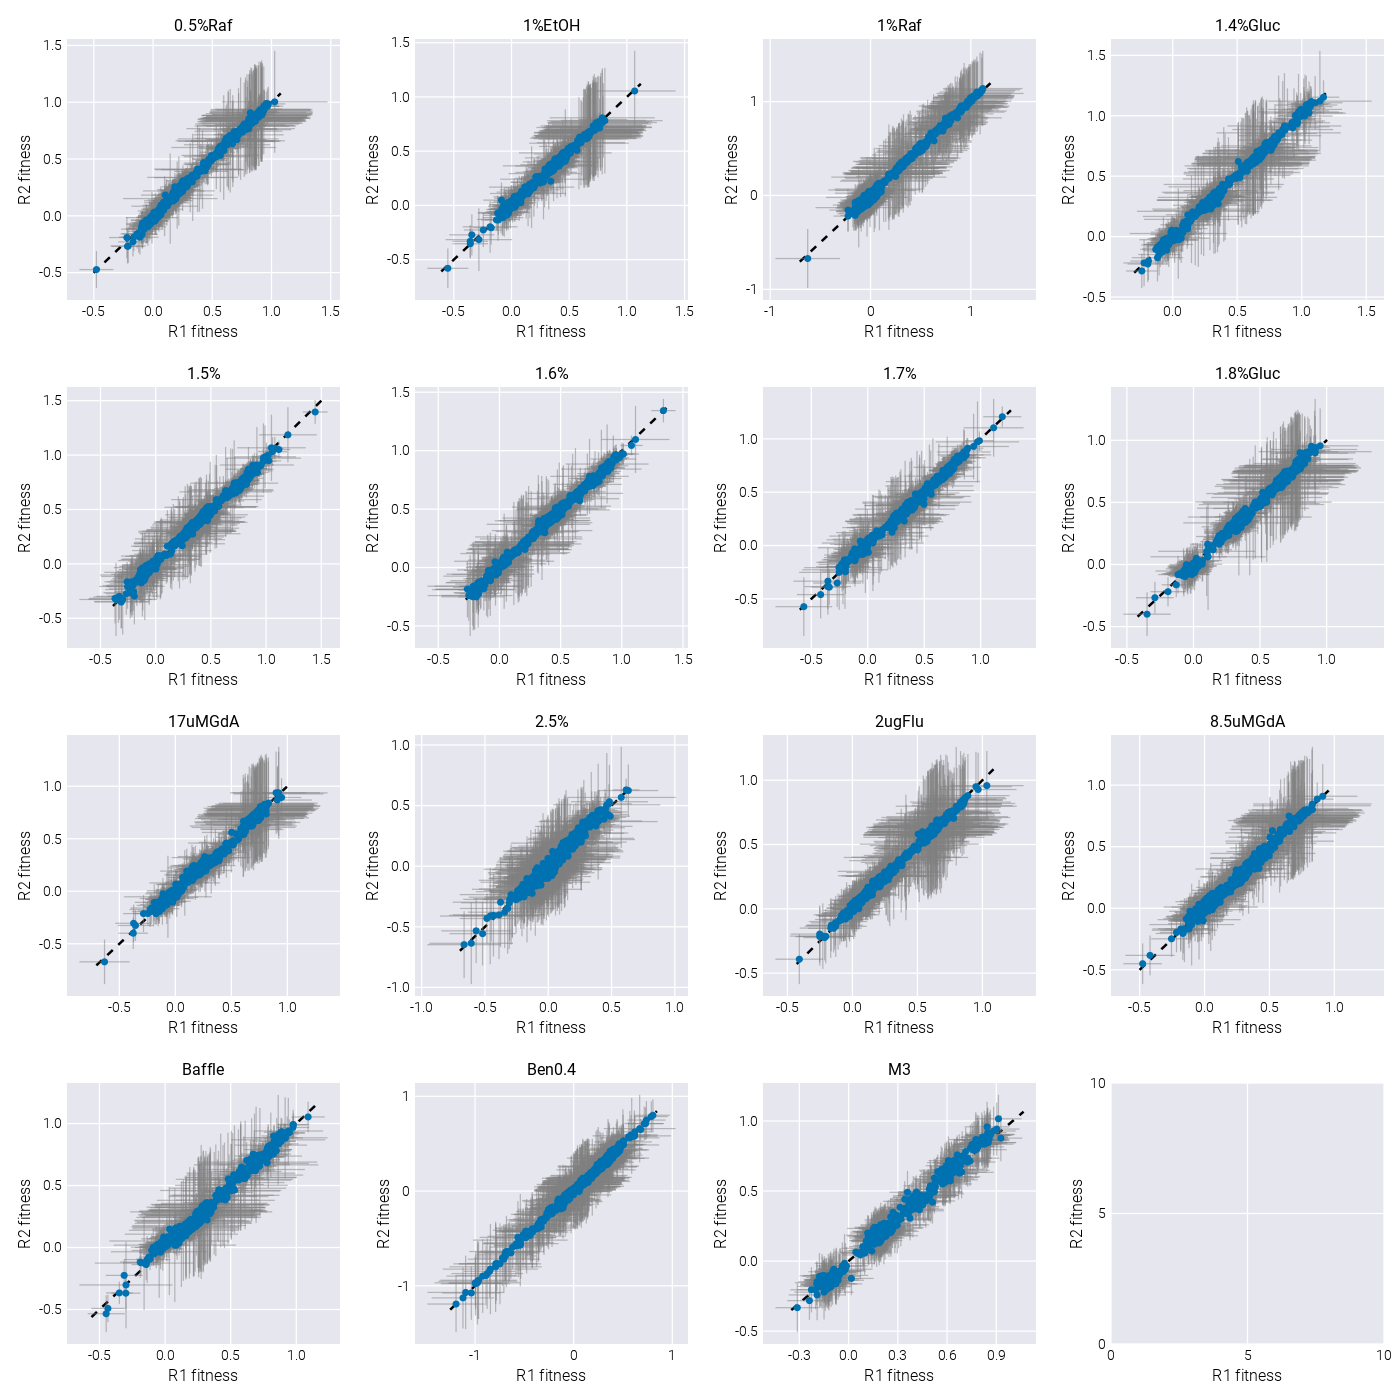

In [13]:
# Group data by environment
df_group = DF.groupby(df_fitness, :env)

# Define number of rows and columns
n_row, n_col = [4, 4]

# Initialize figure
fig = Figure(resolution=(350 * n_col, 350 * n_row))

# Add GridLayout
gl = fig[1, 1] = GridLayout()

# Add axis
axes = [
    Axis(
        gl[i, j],
        xlabel="R1 fitness",
        ylabel="R2 fitness",
    ) for i = 1:n_row for j = 1:n_col
]

# Loop through groups
for (i, data) in enumerate(df_group)
    if first(data.env) == "M3"
        # Extract replicates to plot
        data = data[(data.rep.=="R6").|(data.rep.=="R7"), :]
    end # if

    # Plot identity line
    lines!(
        axes[i],
        repeat([[minimum(data.mean) * 1.05, maximum(data.mean) * 1.05]], 2)...,
        color=:black,
        linestyle=:dash,
        linewidth=2.5
    )

    # Add x-axis error-bars
    errorbars!(
        axes[i],
        data[data.rep.==first(sort(unique(data.rep))), :mean],
        data[data.rep.==last(sort(unique(data.rep))), :mean],
        data[data.rep.==first(sort(unique(data.rep))), :std],
        color=(:gray, 0.5),
        direction=:x
    )
    # Add y-axis error-bars
    errorbars!(
        axes[i],
        data[data.rep.==first(sort(unique(data.rep))), :mean],
        data[data.rep.==last(sort(unique(data.rep))), :mean],
        data[data.rep.==last(sort(unique(data.rep))), :std],
        color=(:gray, 0.5),
        direction=:y
    )
    # Plot R1 vs R2
    scatter!(
        axes[i],
        data[data.rep.==first(sort(unique(data.rep))), :mean],
        data[data.rep.==last(sort(unique(data.rep))), :mean],
        markersize=10
    )
    # Add title
    axes[i].title = first(data.env)
end # for

fig

The agreement between replicates is much higher when using the hierarchical 
model.